<a href="https://colab.research.google.com/github/dot-spinks/machine-learning-25/blob/main/MuonSeedClassifier_QNN/QSVM/iris_qsvc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit_machine_learning
!pip install --upgrade qiskit-machine-learning
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.8 MB/s eta 0:00:00


Train labels unique: [-1  1]
Test labels unique: [-1  1]
Train labels unique: [-1  1]
Test labels unique: [-1  1]
Train labels shape: (15,)
Train features shape: (15, 2)
PegasosQSVC classification test score: 0.9481481481481482


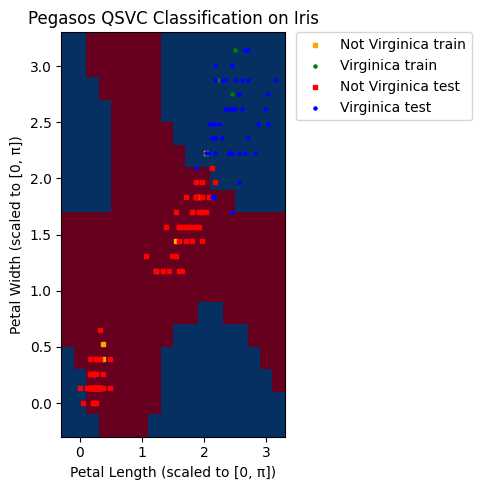

In [ ]:
from sklearn.datasets import load_iris
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load Iris data: petal length and width
iris = load_iris()
features = iris.data[:, 2:4]

# Labels: Virginica=1, others=0
labels = (iris.target == 2).astype(int)

# Scale features to [0, π]
features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(features)

# Split data: train_size=15, no shuffle
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=15, shuffle=True, stratify=labels
)
train_labels_svm = 2 * train_labels - 1
test_labels_svm = 2 * test_labels - 1
print("Train labels unique:", np.unique(train_labels_svm))
print("Test labels unique:", np.unique(test_labels_svm))


# Convert labels from {0,1} to {-1,1}
train_labels_svm = 2 * train_labels - 1
test_labels_svm = 2 * test_labels - 1

num_qubits = 2
tau = 100
C = 1000

from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

print("Train labels unique:", np.unique(train_labels_svm))
print("Test labels unique:", np.unique(test_labels_svm))
print("Train labels shape:", train_labels_svm.shape)
print("Train features shape:", train_features.shape)

# Train
pegasos_qsvc.fit(train_features, train_labels_svm)

# Test accuracy
pegasos_score = pegasos_qsvc.score(test_features, test_labels_svm)
print(f"PegasosQSVC classification test score: {pegasos_score}")

# Create mesh grid for plotting
grid_step = 0.2
margin = 0.2
grid_x, grid_y = np.meshgrid(
    np.arange(-margin, np.pi + margin, grid_step), np.arange(-margin, np.pi + margin, grid_step)
)

meshgrid_features = np.column_stack((grid_x.ravel(), grid_y.ravel()))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
    train_features[:, 0][train_labels == 0],
    train_features[:, 1][train_labels == 0],
    marker="s",
    facecolors='orange',
    edgecolors='orange',
    label="Not Virginica train",
    s=5

)
plt.scatter(
    train_features[:, 0][train_labels == 1],
    train_features[:, 1][train_labels == 1],
    marker="o",
    facecolors='green',
    edgecolors='green',
    label="Virginica train",
    s=5
)

plt.scatter(
    test_features[:, 0][test_labels == 0],
    test_features[:, 1][test_labels == 0],
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="Not Virginica test",
    s=5
)
plt.scatter(
    test_features[:, 0][test_labels == 1],
    test_features[:, 1][test_labels == 1],
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="Virginica test",
    s=5
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos QSVC Classification on Iris")
plt.xlabel("Petal Length (scaled to [0, π])")
plt.ylabel("Petal Width (scaled to [0, π])")
plt.tight_layout()
plt.show()


/tmp/ipython-input-32-2295751505.py:37: UserWarning: Glyph 127804 (\N{BLOSSOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127804 (\N{BLOSSOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


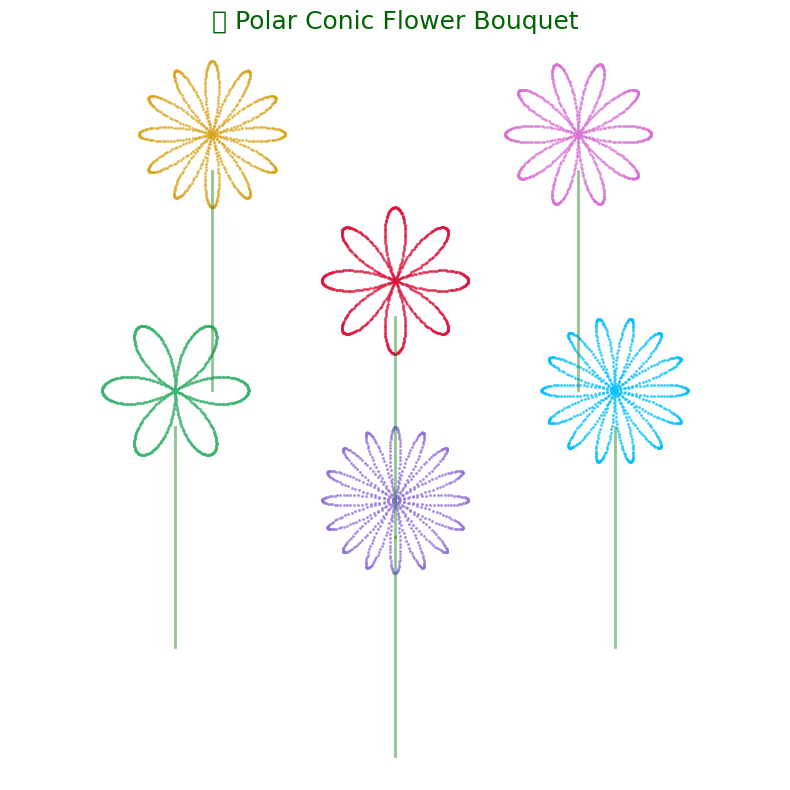

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up canvas
plt.figure(figsize=(8, 8))
plt.axis("equal")
plt.axis("off")

# Flower positions (center x, center y)
centers = [
    (0, 0),
    (2.5, 2),
    (-2.5, 2),
    (3, -1.5),
    (-3, -1.5),
    (0, -3)
]

# Rose curve parameters for each flower
petal_counts = [4, 5, 6, 7, 3, 8]
colors = ['crimson', 'orchid', 'goldenrod', 'deepskyblue', 'mediumseagreen', 'mediumpurple']

# Create each flower
for (cx, cy), k, color in zip(centers, petal_counts, colors):
    theta = np.linspace(0, 2 * np.pi, 800)
    r = 1.0 * np.abs(np.cos(k * theta))  # rose curve
    x = r * np.cos(theta) + cx
    y = r * np.sin(theta) + cy
    plt.scatter(x, y, s=1.5, color=color, alpha=0.6)

# Optional: add a stem
for cx, cy in centers:
    plt.plot([cx, cx], [cy - 0.5, cy - 3.5], color='forestgreen', lw=2, alpha=0.5)

# Title and display
plt.title("🌼 Polar Conic Flower Bouquet", fontsize=18, color='darkgreen')
plt.tight_layout()
plt.show()
